# Multicomponent Precipitation

This example will use a ternary system (Ni-Cr-Al); however, the setup for any multicomponent system is mostly the same.

## Example - The Ni-Cr-Al system

In the Ni-Cr-Al system, $Ni_3(Al,Cr)$ can precipitate into an $\gamma$-Ni (FCC) matrix. As with binary precipitatation, the Thermodynamics module provides some functions to interface with pyCalphad in defining the driving force, growth rate and interfacial composition. Similarly, it is also possible to use user-defined functions for the driving force and nucleation as long as the function parameters and return values are consistent with the ones provides by the Thermodynamics module. Calphad models for the Ni-Cr-Al system was obtained from the STGE database and Dupin et al [1,2]. Mobility data for the Ni-Cr-Al system was obtained from Engstrom and Agren [3].

In [1]:
from kawin.thermo import MulticomponentThermodynamics
from kawin.precipitation import PrecipitateModel, VolumeParameter
import numpy as np

elements = ['NI', 'AL', 'CR', 'VA']
phases = ['FCC_A1', 'FCC_L12']

therm = MulticomponentThermodynamics('NiCrAl.tdb', elements, phases)

model = PrecipitateModel(elements=['Al', 'Cr'])

## Model Inputs

Setting up model parameters is the same as for binary systems. The only difference is that the initial composition needs to be set as an array where the elements in the array will correspond to the same order of elements when the model was defined. In this case, [0.10, 0.085] corresponds to Ni-10Al-8.5Cr (at.%).

In [2]:
model.setInitialComposition([0.098, 0.083])
model.setInterfacialEnergy(0.023)

T = 1073
model.setTemperature(T)

a = 0.352e-9        #Lattice parameter
Va = a**3           #Atomic volume of FCC-Ni
Vb = Va             #Assume Ni3Al has same unit volume as FCC-Ni
atomsPerCell = 4    #Atoms in an FCC unit cell
model.setVolumeAlpha(Va, VolumeParameter.ATOMIC_VOLUME, atomsPerCell)
model.setVolumeBeta(Vb, VolumeParameter.ATOMIC_VOLUME, atomsPerCell)

#Set nucleation sites to dislocations and use defualt value of 5e12 m/m3
#model.setNucleationSite('dislocations')
#model.setNucleationDensity(dislocationDensity=5e12)
model.setNucleationSite('bulk')
model.setNucleationDensity(bulkN0=1e30)

## Surrogate Modeling

For efficiency, a surrogate model can be made on the driving force and interfacial composition. The surrogate models uses radial-basis function (RBF) interpolation and the scale and basis function can be defined (using RBF interpolation from Scipy). 

For multicomponent systems, a surrogate on the driving force and the various terms derived from the curvature of the free energy surface to calculate growth rate and interfacial composition (which will be referred to as "curvature factors") can be made. Both surrogates will need a set of compositions and temperatures to be trained on. When defining the range to train the surrogate model on, it is recommended to extend the range beyond what is expected to occur during the precipitate simulation.

In [3]:
from kawin.thermo import MulticomponentSurrogate, generateTrainingPoints

surr = MulticomponentSurrogate(therm)

#Train driving force surrogate
xAl = np.linspace(0.02, 0.12, 8)
xCr = np.linspace(0.02, 0.12, 8)
xTrain = generateTrainingPoints(xAl, xCr)
surr.trainDrivingForce(xTrain, T)

#Train curvature factors surrogate
xAl = np.linspace(0.05, 0.23, 16)
xCr = np.linspace(0, 0.12, 16)
xTrain = generateTrainingPoints(xAl, xCr)
surr.trainCurvature(xTrain, T)

model.setSurrogate(surr)

## Solving the Model

Solving the model is the same as for binary precipitation.

In [4]:
model.solve(1e6, verbose=True, vIt = 5000)

C:\Users\ury3\OneDrive - LLNL\Documents\Projects\U-C Modeling\kawin-development\kawin\kawin\precipitation\KWNBase.py:1162: RuntimeWarning: divide by zero encountered in scalar divide
  return np.exp(-tau / t)


N	Time (s)	Sim Time (s)	Temperature (K)	Al	Cr	
0	0.0e+00		0.0		1073		9.8000	8.3000	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	0.000e+00		0.0000		0.0000e+00	2.4356e+02

N	Time (s)	Sim Time (s)	Temperature (K)	Al	Cr	
5000	1.3e+04		14.9		1073		8.8218	8.5658	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	6.334e+20		11.5747		3.3014e-08	9.0415e+00

N	Time (s)	Sim Time (s)	Temperature (K)	Al	Cr	
7689	1.0e+06		22.5		1073		8.7929	8.5730	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	8.795e+18		11.9300		1.3884e-07	2.1501e+00



## Plotting

Plotting is also the same as with binary precipitation. Note that plotting composition will plot all components.

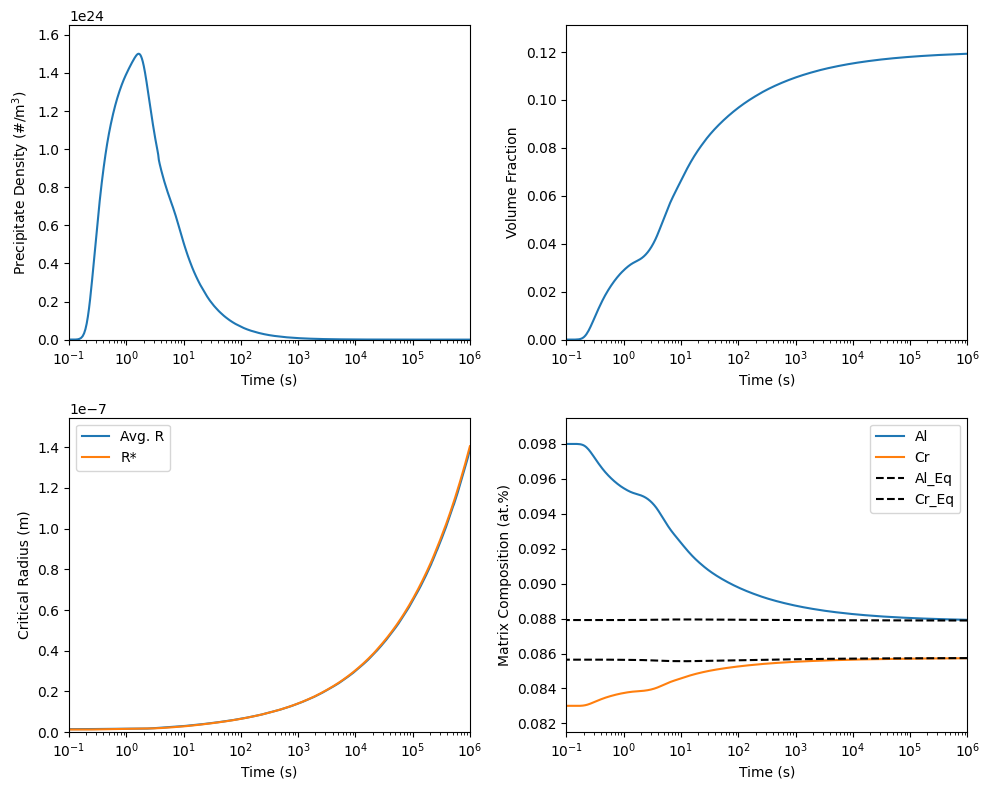

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

bounds = [1e-1, 1e6]
model.plot(axes[0,0], 'Precipitate Density', bounds)
model.plot(axes[0,1], 'Volume Fraction', bounds)
model.plot(axes[1,0], 'Average Radius', bounds, color='C0', label='Avg. R')
model.plot(axes[1,0], 'Critical Radius', bounds, color='C1', label='R*')
axes[1,0].legend(loc='upper left')
model.plot(axes[1,1], 'Composition', bounds)
model.plot(axes[1,1], 'Eq Composition Alpha', bounds, color='k', linestyle='--')

fig.tight_layout()

Since the $Ni_3(Al,Cr)$ precipiates are non-stoichiometric, there are two ways to compute the composition in the matrix. The first way (done above) is to assume infinitely fast diffusion in the precipitates where the composition throughout a particle is the same as the surface composition, which is computed from equilibrium.

The other way is to account for the time-dependent history of the surface composition. So as the precipitate grows, only the volume that is added to the precipitate has the surface composition. We can simulate this by the setInfinitePrecipitateDiffusivity function, which can be applied to all precipitates or a specified one.

In [6]:
model_nodiff = PrecipitateModel(elements=['Al', 'Cr'])

model_nodiff.setInitialComposition([0.098, 0.083])
model_nodiff.setInterfacialEnergy(0.023)
model_nodiff.setTemperature(T)
model_nodiff.setVolumeAlpha(Va, VolumeParameter.ATOMIC_VOLUME, atomsPerCell)
model_nodiff.setVolumeBeta(Vb, VolumeParameter.ATOMIC_VOLUME, atomsPerCell)
model_nodiff.setNucleationSite('bulk')
model_nodiff.setNucleationDensity(bulkN0=1e30)
model_nodiff.setSurrogate(surr)

model_nodiff.setInfinitePrecipitateDiffusivity(False)

model_nodiff.solve(1e6, verbose=True, vIt = 5000)

N	Time (s)	Sim Time (s)	Temperature (K)	Al	Cr	
0	0.0e+00		0.0		1073		9.8000	8.3000	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	0.000e+00		0.0000		0.0000e+00	2.4356e+02

N	Time (s)	Sim Time (s)	Temperature (K)	Al	Cr	
5000	1.3e+04		14.2		1073		8.8371	8.5249	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	6.385e+20		11.7407		3.3086e-08	9.0234e+00

N	Time (s)	Sim Time (s)	Temperature (K)	Al	Cr	
7687	1.0e+06		22.8		1073		8.8093	8.5295	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	8.888e+18		12.1043		1.3903e-07	2.1474e+00



When plotting the matrix composition under these two assumptions shows that the matrix composition under the no diffusion assumption will never reach the equilibrium matrix composition. This is due to how the precipitates will never homogenize to the equilibrium precipitate composition.

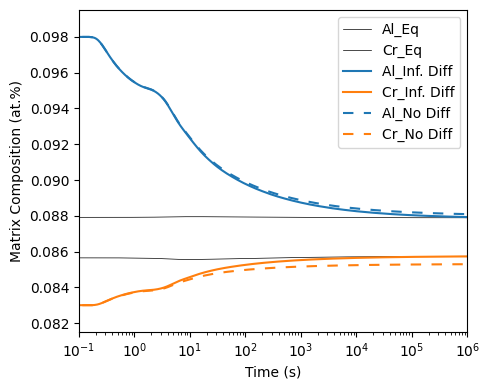

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

bounds = [1e-1, 1e6]
model.plot(axes, 'Eq Composition Alpha', bounds, color='k', linewidth=0.5)
model.plot(axes, 'Composition', bounds, label='Inf. Diff')
model_nodiff.plot(axes, 'Composition', bounds, label='No Diff', linestyle=(0,(5,5)))

axes.legend(loc='upper right')

fig.tight_layout()

## References

1. A. T. Dinsdale, "SGTE Data for Pure Elements" *Calphad* 15 (1991) p. 317
2. N. Dupin, I. Ansara and B. Sundman, "Thermodynamic Re-assessment of the Ternary System Al-Cr-Ni" *Calphad* 25 (2001) p. 279
3. A. Engstrom and J. Agren, "Assessment of Diffusional Mobilities in Face-centered Cubic Ni-Cr-Al Alloys" *Z. Metallkd.* 87 (1996) p. 92